# Testing JSBSim with PathSim

In example JSBSim is used in conjunction with the [PathSim](https://pathsim.org/), a Python native system modeling library.

## Initializing an FDM object

Load the Global 5000 flight dynamics model (FDM): `global5000`. Instantiate an object `fdm` to prepare tthe simulation. 

In [1]:
import os
import jsbsim
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

# Relative path to the directory where the flight model is stored
# Note - Aircraft directory needs to be writeable in order to modify the cg
PATH_TO_JSBSIM_FILES="../.."

print(f'=================================================================')
print(f'Current working directory: {os.getcwd()}')

# Global variables that must be modified to match your particular need
# The aircraft name
# Note - It should match the exact spelling of the model file
AIRCRAFT_NAME="global5000"

# Avoid flooding the console with log messages
jsbsim.FGJSBBase().debug_lvl = 0

# Instantiate the FDMExec object and load the aircraft
fdm = jsbsim.FGFDMExec(PATH_TO_JSBSIM_FILES)

load_status = fdm.load_model(AIRCRAFT_NAME)

print(f'=================================================================')

Current working directory: f:\agodemar\jsbsim\examples\python


## Inspect the aircraft property tree and define some reference variable

In [2]:
ac_xml_tree = ET.parse(os.path.join(fdm.get_root_dir(), f'aircraft/{AIRCRAFT_NAME}/{AIRCRAFT_NAME}.xml'))
ac_xml_root = ac_xml_tree.getroot()

# Get the empty weight from aircraft xml [assume lbs]
for x in ac_xml_root.findall('mass_balance'):
        w = x.find('emptywt').text

empty_weight = float(w)

# Get the original CG from aircraft xml, assum inches from Construction axes origin
for loc in ac_xml_root.findall('mass_balance/location'):
        x_cg_ = loc.find('x').text

x_cg_0 = float(x_cg_)

# Assume a payload, midweight, lb
payload_0 = 15172/2

# Fuel max for Global5000, lbm
fuelmax = 8097.63

# Assume the mass of fuel, half tanks, lb
fuel_per_tank = fuelmax/2


# Select a speed to run the simulation at, knots
speed_cas = 250

# Assume a flight altitude
h_ft_0 = 15000

# Fuel max for Global5000, lbm
fuelmax = 8097.63

weight_0 = empty_weight + payload_0 + fuel_per_tank*3

# Assume a zero flight path angle, gamma_0
gamma_0 = 0

print("-----------------------------------------")
print("Altitude {} ft, Weight {} lb, CoG-x {} in".format(h_ft_0, weight_0, x_cg_0))
print("-----------------------------------------")
print("Running simulation at initial CAS = {} kn, and Altitude = {} ft".format(speed_cas, h_ft_0))
print("-----------------------------------------")

-----------------------------------------
Altitude 15000 ft, Weight 67967.445 lb, CoG-x 790.82 in
-----------------------------------------
Running simulation at initial CAS = 250 kn, and Altitude = 15000 ft
-----------------------------------------


## Perform a level-flight trim at the given altitude, and airspeed

In [3]:
# Set engines running
fdm['propulsion/set-running'] = -1
trim_results = []
trim_results_fcs = []

fdm['ic/h-sl-ft'] = h_ft_0
fdm['ic/vc-kts'] = speed_cas
fdm['ic/gamma-deg'] = gamma_0
fdm['propulsion/tank[0]/contents-lbs'] = fuel_per_tank
fdm['propulsion/tank[1]/contents-lbs'] = fuel_per_tank
fdm['propulsion/tank[2]/contents-lbs'] = fuel_per_tank
fdm['inertia/pointmass-weight-lbs[0]'] = payload_0

# Initialize the aircraft with initial conditions
fdm.run_ic()

# Run fdm model
fdm.run()

# Trim the aircraft to initial conditions
fdm['simulation/do_simple_trim'] = 1
fdm.run()

print("-----------------------------------------")

trim_results.append((fdm['velocities/vc-kts'], fdm['aero/alpha-deg']))
trim_results_fcs.append((fdm['fcs/elevator-pos-rad'], fdm['fcs/elevator-pos-deg'], fdm['fcs/elevator-pos-norm']))

# Print trim results
print("Trim results:")
print("CAS (knots): {}\nAoA (deg): {}".format(trim_results[0][0], trim_results[0][1]))
print("Elevator pos (rad): {}\nElevator pos (deg): {}\nElevator pos (norm): {}".format(trim_results_fcs[0][0], trim_results_fcs[0][1], trim_results_fcs[0][2]))
print("-----------------------------------------")

-----------------------------------------
Trim results:
CAS (knots): 249.99999925312514
AoA (deg): 4.317141647704533
Elevator pos (rad): -0.05171547537636804
Elevator pos (deg): -2.963078474578621
Elevator pos (norm): -0.14775850107533725
-----------------------------------------


## Setting up PathSim objects

In [4]:
import numpy as np
from pathsim import Simulation, Connection
from pathsim.blocks import (
    DynamicalFunction, Source, StepSource, Adder, Scope
)

# An example of 'Dynamical function' that takes the elevator command as input and outputs the angle of attack
def f_aircraft(u, t):
    fdm["fcs/elevator-cmd-norm"] = u
    fdm.run()
    return fdm["aero/alpha-deg"]

dynFunAircraft = DynamicalFunction(f_aircraft)

# Constant signal function that outputs the elevator command (normalized) at trim
def f_elevator_command_at_trim(t):
    return trim_results_fcs[0][2]

srcElevatorAtTrim = Source(f_elevator_command_at_trim)

# -- Example Simulation --

# https://docs.pathsim.org/pathsim/v0.16.7/api

# Create a source signal (Gaussian pulse)
# src = GaussianPulseSource(amplitude=0.1, f_max=1.0, tau=0.8)

# starts at 0, jumps to -0.1 at 1, jumps to 0 at 2
srcStepElevator = StepSource(amplitude=[-0.1, 0, 0.1, 0], tau=[10, 11, 12, 13])

addedElevatorSignals = Adder('++')

# Create a scope to visualize the control input and the VCO output
sco = Scope(labels=["U1=Elevator Command Normalized (x100)", "Alpha (deg)"])

def f_gain(u, t):
    return 100.0 * (trim_results_fcs[0][2] + u)

ampElevatorNormalized = DynamicalFunction(f_gain)

# Define blocks
blocks = [
    srcElevatorAtTrim, srcStepElevator, 
    addedElevatorSignals, dynFunAircraft, 
    ampElevatorNormalized,
    sco
]

# Define connections
connections = [
    Connection(srcElevatorAtTrim, addedElevatorSignals[0]),
    Connection(srcStepElevator, addedElevatorSignals[1]),
    Connection(addedElevatorSignals, dynFunAircraft),
    Connection(addedElevatorSignals, ampElevatorNormalized),
    Connection(ampElevatorNormalized, sco[0]),
    Connection(dynFunAircraft, sco[1])
]

# Initialize simulation
# Use a small time step (dt) to capture the 100 Hz oscillation
sim = Simulation(
    blocks, connections, 
    dt=1e-3, log=True)

print("Running simulation...")
sim.run(40.0)

19:43:58 - INFO - LOGGING (log: True)
19:43:58 - INFO - BLOCKS (total: 6, dynamic: 0, static: 6, eventful: 1)
19:43:58 - INFO - GRAPH (nodes: 6, edges: 6, alg. depth: 3, loop depth: 0, runtime: 0.049ms)
Running simulation...
19:43:58 - INFO - STARTING -> TRANSIENT (Duration: 40.00s)
19:43:58 - INFO - --------------------   1% | 0.0s<4.2s | 9533.6 it/s
19:43:59 - INFO - ####----------------  20% | 0.9s<3.2s | 9996.2 it/s
19:44:00 - INFO - ########------------  40% | 1.7s<2.3s | 10406.5 it/s
19:44:01 - INFO - ############--------  60% | 2.6s<1.6s | 10038.3 it/s
19:44:02 - INFO - ################----  80% | 3.4s<0.8s | 10016.3 it/s
19:44:03 - INFO - #################### 100% | 4.2s<--:-- | 10501.5 it/s
19:44:03 - INFO - FINISHED -> TRANSIENT (total steps: 40001, successful: 40001, runtime: 4238.96 ms)


{'total_steps': 40001,
 'successful_steps': 40001,
 'runtime_ms': 4238.957499997923}

Scope recording_data shape: (40002, 2)
-----------------------------------------


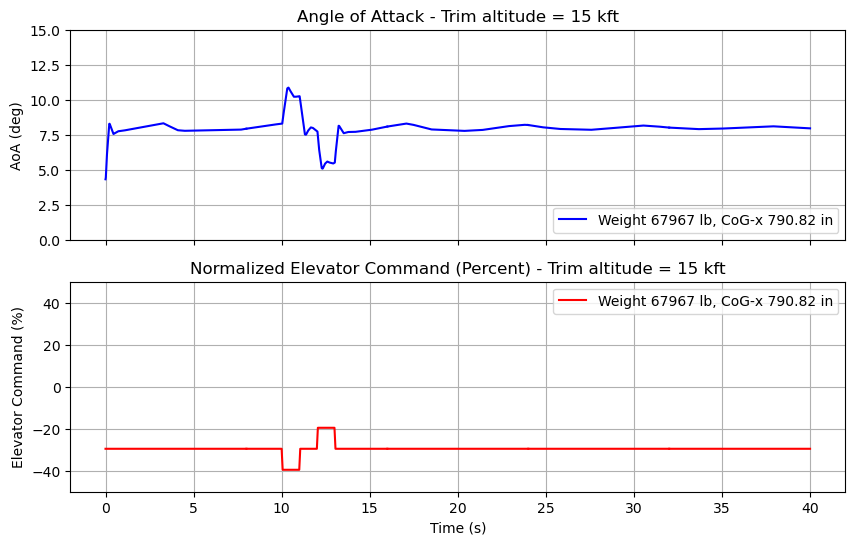

In [5]:
%matplotlib inline
#sco.plot()
#plt.show()


print("Scope recording_data shape: {}".format(np.array(sco.recording_data[:]).shape))
print("-----------------------------------------")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1.plot(sco.recording_time, np.array(sco.recording_data[:])[:,1],
         label="Weight {0:.0f} lb, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         linestyle='-', color='blue')
ax1.set_title("Angle of Attack - Trim altitude = {0:.0f} kft".format(h_ft_0/1000))
ax1.set_ylabel('AoA (deg)')
ax1.grid()
ax1.set_ylim(0, 15)
ax1.legend(loc='lower right')

ax2.plot(sco.recording_time, np.array(sco.recording_data[:])[:,0],
         label="Weight {0:.0f} lb, CoG-x {2:.2f} in".format(weight_0, h_ft_0/1000, x_cg_0),
         linestyle='-', color='red')
ax2.set_title("Normalized Elevator Command (Percent) - Trim altitude = {0:.0f} kft".format(h_ft_0/1000))
ax2.legend(loc='upper right')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Elevator Command (%)')
ax2.grid()
ax2.set_ylim(-50, 50)

plt.show()

